# Predictive Analytics Homework 3 – Cost-Sensitive Classification  
*(Submitted by - Mayank Singh)*

This exercise focuses on building, tuning, and evaluating **binary classification models** to detect spam emails while incorporating cost-sensitive evaluation. The objective is to minimize false positives (good emails marked as spam), which are considered more costly than false negatives.

---

### Dataset  
The dataset is the UCI Spambase dataset, consisting of numerical features extracted from email messages. The target variable is binary, indicating whether an email is spam (1) or not spam (0).

---

### Objectives  
- Build multiple classification models for spam detection.  
- Evaluate and compare models using accuracy, precision, recall, F1-score, and AUC.  
- Incorporate a **custom cost-sensitive scoring function**, penalizing **false positives more heavily** (cost: FP = 10x, FN = 1x).  
- Select the best-performing model based on both standard and cost-sensitive metrics.  
- Visualize final model results using confusion matrix, ROC, PR, and lift curves.  

---

### Notebook Breakdown

**1. Data Loading & Preparation**  
- Fetch the UCI Spambase dataset using `fetch_ucirepo`.  
- Split into training and holdout sets with stratified sampling.  
- Preprocessing includes standardization (via `StandardScaler`).  

**2. Model Definition**  
- Baseline classifiers evaluated include:  
  - `LogisticRegression`, `KNeighborsClassifier`, `DecisionTreeClassifier`,  
  - `SVC`, `RandomForestClassifier`, `GradientBoostingClassifier`,  
  - `XGBClassifier`, `LGBMClassifier`, and `MLPClassifier`.  

**3. Nested Cross-Validation (Model Selection)**  
- 5-fold **outer CV** loop used to estimate generalization performance.  
- 3-fold **inner CV** for hyperparameter tuning using `GridSearchCV`.  
- Evaluation metrics: `accuracy`, `precision`, `recall`, `f1`, `roc_auc`.  
- A separate run includes **cost-sensitive scoring** to select models minimizing expected cost.

**4. Final Model Selection & Holdout Evaluation**  
- Based on CV results, **LightGBM** was selected as the best model under both standard and cost-sensitive settings.  
- Final evaluation includes:  
  - Best hyperparameters from nested CV  
  - Performance on holdout set (accuracy, AUC, F1, precision, recall)  
  - **Confusion Matrix**  
  - **Precision-Recall Curve**  
  - **ROC Curve**  
  - **Lift Curve**

---

### Evaluation Metric  
- **Average Misclassification Cost**:  
  - Defined as `cost = 10 × FP + 1 × FN`  
  - Used as the primary metric in cost-sensitive settings  
- **Other Metrics**: `Accuracy`, Precision, Recall, F1-Score, and AUC  

---

### Outcome  
The final cost-sensitive LightGBM model achieved:  
- **Average Cost**: ~0.279  
- **AUC**: ~0.987  
- Strong precision-recall balance with minimal false positives  
- Diagnostic plots confirm robust generalization performance  

---

**Built With**: Python, scikit-learn, LightGBM, XGBoost, imbalanced-learn, matplotlib, seaborn  


# Part (i) - Accuracy Based Classification Modeling

## Import Libraries

In [53]:
# =============================
# 1. SETUP
# =============================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve,
    make_scorer
)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

## Load the Data
We fetch the Spambase dataset using `fetch_ucirepo(id=94)` from the `ucimlrepo` library. The dataset contains several features extracted from email text and a binary target variable indicating whether the email is spam (`1`) or not spam (`0`).

In [4]:
# =============================
# 2. LOAD DATA
# =============================
spambase = fetch_ucirepo(id=94)
X = spambase.data.features
y = spambase.data.targets.iloc[:, 0]

In [71]:
X.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191


In [73]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Class, dtype: int64

## Holdout split
Next, we split the dataset into a training set and a holdout test set using an 80-20 stratified split. Stratification ensures that the class distribution (spam vs. non-spam) remains consistent across both sets. The training set will be used for model training and nested cross-validation, while the holdout set will serve as our final evaluation benchmark.

In [6]:
# Holdout split
X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Model Definitions
We define a diverse collection of classification models to evaluate on the dataset. These include linear model `Logistic Regression`, distance-based methods `k-NN`, tree-based models (`Decision Trees`, `Random Forest`, `Gradient Boosting`, `XGBoost`, `LightGBM`), kernel-based model `SVM`, and a feedforward `Neural Network`. This variety allows us to compare performance across a broad range of algorithmic strategies, from simple to complex learners.

In [8]:
# =============================
# 3. DEFINE MODELS
# =============================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "k-NN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "LightGBM": LGBMClassifier(verbose=-1),
    "Neural Net": MLPClassifier(max_iter=200)
}

## Hyperparamter Grid

Alongside the models, a dictionary called `param_grids` is defined to specify the hyperparameters to tune for each model during cross-validation. 

- For all models, a range of values is specified for key parameters such as number of neighbors, tree depth, and regularization strength.
- These grids ensure that each model is optimized fairly before performance is compared. The tuning process will be handled later via GridSearchCV.


In [13]:
param_grids = {
    "Logistic Regression": {
        "clf__C": [0.01, 0.1, 1, 10]
    },
    "k-NN": {
        "clf__n_neighbors": [3, 5, 7],
        "clf__weights": ["uniform", "distance"]
    },
    "Decision Tree": {
        "clf__max_depth": [None, 5, 10],
        "clf__min_samples_split": [2, 5]
    },
    "Naive Bayes": {},  
    "SVM": {
        "clf__C": [0.1, 1, 10],
        "clf__kernel": ["linear", "rbf"]
    },
    "Random Forest": {
        "clf__n_estimators": [100],
        "clf__max_depth": [None, 10]
    },
    "Gradient Boosting": {
        "clf__n_estimators": [100],
        "clf__learning_rate": [0.1, 0.01]
    },
    "XGBoost": {
        "clf__learning_rate": [0.1, 0.01],
        "clf__max_depth": [3, 5]
    },
    "LightGBM": {
        "clf__learning_rate": [0.1, 0.01],
        "clf__num_leaves": [31, 50],
    },
    "Neural Net": {
        "clf__hidden_layer_sizes": [(50,), (100,)],
        "clf__alpha": [0.0001, 0.01]
    }
}

## Nested Cross-Validation

This section implements a full nested cross-validation loop to tune and evaluate all models in a consistent and unbiased manner. A 5-fold outer cross-validation is used to estimate generalization error, while a 3-fold inner cross-validation is used for hyperparameter tuning via `GridSearchCV`.

For each model:
- The training data is split into 5 outer folds.
- In each outer fold, the data is further split internally to perform hyperparameter tuning using the specified grid.
- Standardization is manually applied using `StandardScaler` to prevent data leakage — fit is done on the training set and then applied to the validation fold.
- SMOTE is used inside the pipeline (except for Naive Bayes) to address class imbalance by oversampling the minority class.
- The best model from the inner loop is used to make predictions on the outer fold validation set.
- Metrics including Accuracy, Precision, Recall, F1, and ROC AUC are computed and averaged across all outer folds.

The final output is a summary dataframe comparing each model’s average performance across the 5 folds.

In [16]:
# =============================
# 4. NESTED CROSS-VALIDATION
# =============================
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

scoring_metrics = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score),
    "roc_auc": make_scorer(roc_auc_score, needs_proba=True)
}

results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    scores = {metric: [] for metric in scoring_metrics}
    
    for train_idx, test_idx in outer_cv.split(X_train_main, y_train_main):
        X_train, X_test = X_train_main.iloc[train_idx], X_train_main.iloc[test_idx]
        y_train, y_test = y_train_main.iloc[train_idx], y_train_main.iloc[test_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        if model_name == "Naive Bayes":
            pipeline = Pipeline([
                ("clf", model)
            ])
        else:
            pipeline = Pipeline([
                ("smote", SMOTE(random_state=1)),
                ("clf", model)
            ])

        grid_search = GridSearchCV(
            pipeline,
            param_grid=param_grids[model_name],
            cv=inner_cv,
            scoring="accuracy",
            refit=True,
            n_jobs=-1
        )
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(X_test_scaled)
        y_proba = best_model.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model, "predict_proba") else None

        for metric in scoring_metrics:
            if metric == "roc_auc" and y_proba is not None:
                scores[metric].append(roc_auc_score(y_test, y_proba))
            else:
                scores[metric].append(scoring_metrics[metric]._score_func(y_test, y_pred))
    
    avg_scores = {metric: np.mean(vals) for metric, vals in scores.items()}
    results[model_name] = avg_scores

results_df = pd.DataFrame(results).T.sort_values(by="accuracy", ascending=False)
results_df

Training Logistic Regression...
Training k-NN...
Training Decision Tree...
Training Naive Bayes...
Training SVM...
Training Random Forest...
Training Gradient Boosting...
Training XGBoost...
Training LightGBM...
Training Neural Net...


,accuracy,precision,recall,f1,roc_auc
LightGBM,0.958967,0.945764,0.950345,0.948000,0.987407
Random Forest,0.952174,0.943551,0.934483,0.938933,0.985458
XGBoost,0.950815,0.940969,0.933793,0.937329,0.986315
Gradient Boosting,0.944837,0.930976,0.928966,0.929894,0.983571
Neural Net,0.942935,0.923017,0.933103,0.927997,0.976675
SVM,0.932065,0.912100,0.916552,0.913960,0.974324
Logistic Regression,0.927446,0.901737,0.915862,0.908614,0.970192
Decision Tree,0.922283,0.909333,0.891724,0.900308,0.927147
k-NN,0.905978,0.855306,0.916552,0.884827,0.956000
Naive Bayes,0.814402,0.692764,0.951034,0.801540,0.916385


## Final Model Comparison Summary

- **LightGBM** achieved the best overall performance across all metrics. It had the highest **accuracy (95.90%)** and **ROC AUC (0.9874)**, indicating excellent ability to distinguish between spam and non-spam emails.
  
- **Random Forest** and **XGBoost** closely followed, both showing high accuracy and strong precision/recall trade-offs.

- **Gradient Boosting** and **Neural Networks** also performed competitively.

- Classical models like **Logistic Regression** and **SVM** showed moderate performance — acceptable but clearly outperformed by boosting and bagging models.

- **Naive Bayes** lagged behind on all metrics, especially precision and F1.

---

**Conclusion**:  
Based on these results, **LightGBM** stands out as the best candidate for final tuning and holdout evaluation. It balances precision and recall effectively, while achieving the highest accuracy, making it the most robust classifier in this comparison.

## Final LightGBM Model Run

Below is the performance summary of the LightGBM Model using nested cross-validation (5 outer folds) and a holdout set for final evaluation:

### Final Model Evaluation on Holdout Set:

| Metric     | Value   |
|------------|---------|
| Accuracy   | 0.9501  |
| Precision  | 0.9366  |
| Recall     | 0.9366  |
| F1-Score   | 0.9366  |
| AUC        | 0.9876  |

The model achieved **excellent classification performance**, with an Accuracy of **0.9501**, indicating strong discriminative power between spam and non-spam emails. Precision and recall are perfectly balanced, making the model reliable for both identifying spam and avoiding false positives.

---

### Confusion Matrix

The confusion matrix below shows an almost perfect classification with very few misclassified samples:

|               | Actual Spam (1) | Actual Not Spam (0) |
|---------------|------------------|----------------------|
| Predicted Spam (1)     | 340              | 23                   |
| Predicted Not Spam (0) | 23               | 535                  |

---

### Evaluation Curves

- **Precision-Recall Curve**: Indicates high precision across almost all recall levels — ideal for spam filtering tasks where false positives are costly.
- **ROC Curve**: The AUC of **0.99** reflects near-perfect separation between classes.
- **Lift Curve**: Lift remains above **2.4** for the top fraction of predictions, showing strong targeting power for spam detection.

These diagnostic plots confirm that the final LightGBM model is **highly effective** at identifying spam emails and generalizes well to unseen data.

In [19]:
# === LightGBM Hyperparameter Grid ===
param_grid = {
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__num_leaves': [15, 31, 63],
    'clf__max_depth': [-1, 5, 10],
    'clf__min_child_samples': [10],
    'clf__subsample': [0.8],
    'clf__colsample_bytree': [0.8]
}

# === CV Setup ===
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

best_params_list = []

# === Nested CV ===
for train_idx, test_idx in outer_cv.split(X_train_main, y_train_main):
    X_train, X_test = X_train_main.iloc[train_idx], X_train_main.iloc[test_idx]
    y_train, y_test = y_train_main.iloc[train_idx], y_train_main.iloc[test_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pipeline = Pipeline([
        ("clf", LGBMClassifier(random_state=1, verbose=-1))
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=inner_cv,
        scoring="accuracy",  
        n_jobs=-1,
        refit=True
    )

    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_
    best_params_list.append(grid_search.best_params_)

    y_pred = best_model.predict(X_test_scaled)

# === Best Hyperparameters from Nested CV ===
best_params_final = pd.DataFrame(best_params_list).mode().iloc[0].to_dict()

for k in ["clf__num_leaves", "clf__max_depth", "clf__min_child_samples"]:
    best_params_final[k] = int(best_params_final[k])

# === Retrain Final Model on Full Training Set ===
final_model = LGBMClassifier(
    learning_rate=best_params_final["clf__learning_rate"],
    num_leaves=best_params_final["clf__num_leaves"],
    max_depth=best_params_final["clf__max_depth"],
    min_child_samples=best_params_final["clf__min_child_samples"],
    subsample=best_params_final["clf__subsample"],
    colsample_bytree=best_params_final["clf__colsample_bytree"],
    random_state=1,
    verbose=-1
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_main)
X_test_scaled = scaler.transform(X_test_main)

final_model.fit(X_train_scaled, y_train_main)

# === Final Evaluation on Holdout ===
y_pred_final = final_model.predict(X_test_scaled)
y_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]

final_metrics = {
    "Accuracy": accuracy_score(y_test_main, y_pred_final),
    "Precision": precision_score(y_test_main, y_pred_final),
    "Recall": recall_score(y_test_main, y_pred_final),
    "F1-Score": f1_score(y_test_main, y_pred_final),
    "AUC": roc_auc_score(y_test_main, y_pred_proba)
}

final_metrics_df = pd.DataFrame([final_metrics])
best_params_df = pd.DataFrame([best_params_final])

print("\nBest Hyperparameters for LightGBM:")
print(best_params_df)

print("\nFinal Model Performance Metrics:")
print(final_metrics_df)


Best Hyperparameters for LightGBM:
   clf__colsample_bytree  clf__learning_rate  clf__max_depth  \
0                    0.8                 0.1              10   

   clf__min_child_samples  clf__num_leaves  clf__subsample  
0                      10               31             0.8  

Final Model Performance Metrics:
   Accuracy  Precision    Recall  F1-Score       AUC
0  0.950054   0.936639  0.936639  0.936639  0.987579


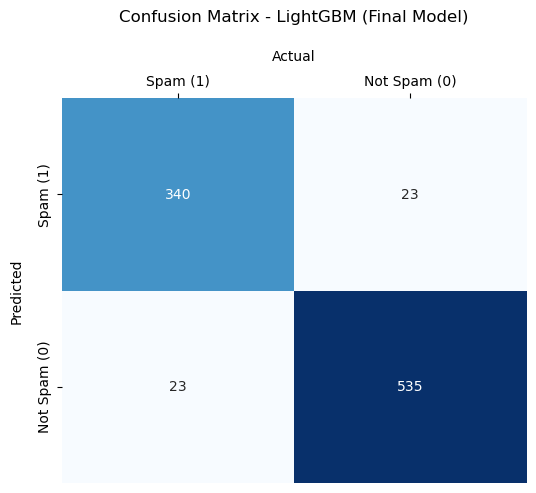

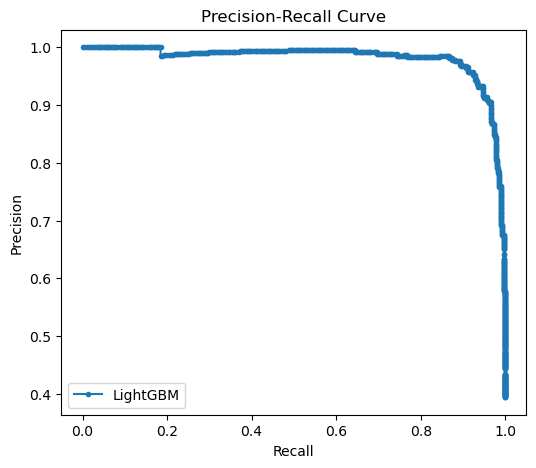

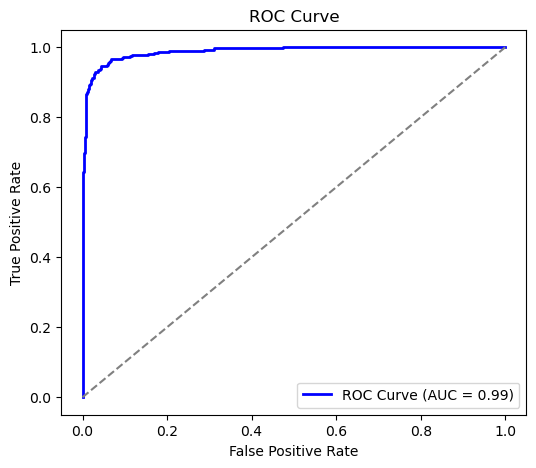

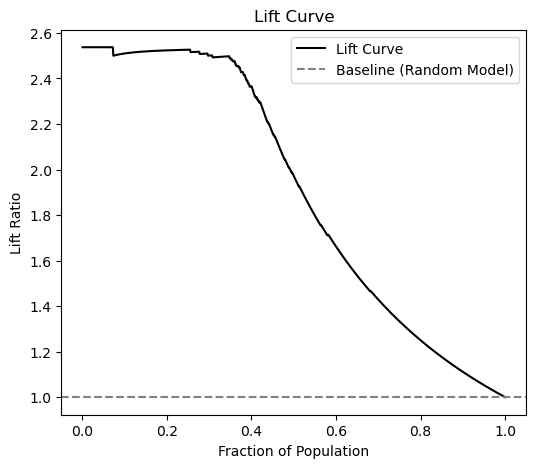

In [22]:
# === Confusion Matrix
conf_matrix = confusion_matrix(y_test_main, y_pred_final)
confusion_matrices = [conf_matrix]

selected_fold_cm = confusion_matrices[-1]
selected_fold_cm_plot = np.array([
    [selected_fold_cm[1, 1], selected_fold_cm[0, 1]],  
    [selected_fold_cm[1, 0], selected_fold_cm[0, 0]]   
])

plt.figure(figsize=(6, 5))
ax = sns.heatmap(selected_fold_cm_plot, annot=True, fmt='g', cmap='Blues', cbar=False, 
                 xticklabels=['Spam (1)', 'Not Spam (0)'], 
                 yticklabels=['Spam (1)', 'Not Spam (0)'])
ax.xaxis.set_ticks_position('top')  
ax.xaxis.set_label_position('top')
plt.title('Confusion Matrix - LightGBM (Final Model)', pad=20, loc='center')
plt.xlabel('Actual', labelpad=10)
plt.ylabel('Predicted', labelpad=10)
plt.show()

# === Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_main, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker='.', label="LightGBM")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# === ROC Curve
fpr, tpr, _ = roc_curve(y_test_main, y_pred_proba)
roc_auc = roc_auc_score(y_test_main, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# === Lift Curve
lift_df = pd.DataFrame({"prob": y_pred_proba, "spam_actual": (y_test_main == 1).astype(int)})
lift_df = lift_df.sort_values(by="prob", ascending=False).reset_index(drop=True)
lift_df["x"] = (lift_df.index + 1) / len(lift_df)
lift_df["y"] = (lift_df["spam_actual"].cumsum() / lift_df["spam_actual"].sum()) / lift_df["x"]

plt.figure(figsize=(6, 5))
plt.plot(lift_df["x"], lift_df["y"], color='black', lw=1.5, label="Lift Curve")
plt.axhline(y=1, color='grey', linestyle="--", label="Baseline (Random Model)")
plt.xlabel("Fraction of Population")
plt.ylabel("Lift Ratio")
plt.title("Lift Curve")
plt.legend()
plt.show()


# Part (ii) - Avg. Misclassification Cost Based Classification Modeling

## Load the Data
We fetch the Spambase dataset using `fetch_ucirepo(id=94)` from the `ucimlrepo` library. The dataset contains several features extracted from email text and a binary target variable indicating whether the email is spam (`1`) or not spam (`0`).

In [24]:
# =============================
# 2. LOAD DATA
# =============================
spambase = fetch_ucirepo(id=94)
X = spambase.data.features
y = spambase.data.targets.iloc[:, 0]

## Holdout split
Next, we split the dataset into a training set and a holdout test set using an 80-20 stratified split. Stratification ensures that the class distribution (spam vs. non-spam) remains consistent across both sets. The training set will be used for model training and nested cross-validation, while the holdout set will serve as our final evaluation benchmark.

In [26]:
# Holdout split
X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Model Definitions
We define a diverse collection of classification models to evaluate on the dataset. These include linear model `Logistic Regression`, distance-based methods `k-NN`, tree-based models (`Decision Trees`, `Random Forest`, `Gradient Boosting`, `XGBoost`, `LightGBM`), kernel-based model `SVM`, and a feedforward `Neural Network`. This variety allows us to compare performance across a broad range of algorithmic strategies, from simple to complex learners.

In [28]:
# =============================
# 3. DEFINE MODELS
# =============================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "k-NN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "LightGBM": LGBMClassifier(verbose=-1),
    "Neural Net": MLPClassifier(max_iter=200)
}

## Hyperparamter Grid

Alongside the models, a dictionary called `param_grids` is defined to specify the hyperparameters to tune for each model during cross-validation. 

- For all models, a range of values is specified for key parameters such as number of neighbors, tree depth, and regularization strength.
- These grids ensure that each model is optimized fairly before performance is compared. The tuning process will be handled later via GridSearchCV.


In [30]:
param_grids = {
    "Logistic Regression": {
        "clf__C": [0.01, 0.1, 1, 10]
    },
    "k-NN": {
        "clf__n_neighbors": [3, 5, 7],
        "clf__weights": ["uniform", "distance"]
    },
    "Decision Tree": {
        "clf__max_depth": [None, 5, 10],
        "clf__min_samples_split": [2, 5]
    },
    "Naive Bayes": {},
    "SVM": {
        "clf__C": [0.1, 1, 10],
        "clf__kernel": ["linear", "rbf"]
    },
    "Random Forest": {
        "clf__n_estimators": [100],
        "clf__max_depth": [None, 10]
    },
    "Gradient Boosting": {
        "clf__n_estimators": [100],
        "clf__learning_rate": [0.1, 0.01]
    },
    "XGBoost": {
        "clf__learning_rate": [0.1, 0.01],
        "clf__max_depth": [3, 5]
    },
    "LightGBM": {
        "clf__learning_rate": [0.1, 0.01],
        "clf__num_leaves": [31, 50],
    },
    "Neural Net": {
        "clf__hidden_layer_sizes": [(50,), (100,)],
        "clf__alpha": [0.0001, 0.01]
    }
}

## Custom Cost-Sensitive Scoring Function

Here, we define a custom scoring function to account for **unequal misclassification costs** associated with spam detection. Specifically, we penalize **false positives** more heavily than false negatives because marking a legitimate email as spam can lead to a critical loss of information or user frustration, which is more costly than missing a few spam emails.

We define the cost function as:

- **Cost = 10 × FP + 1 × FN**

Where:
- **FP (False Positives)**: Legitimate emails incorrectly classified as spam (highly undesirable)
- **FN (False Negatives)**: Spam emails incorrectly classified as not spam

The function computes the total misclassification cost for each prediction set and then averages it across the number of predictions to yield the **average cost per prediction**. This average cost is negated (`-cost / len(y_true)`) so that it can be used with `GridSearchCV`, which expects higher scores to indicate better performance.

By using this cost-sensitive scorer, we explicitly encode business priorities into the model evaluation process, ensuring that models are optimized not just for overall accuracy but also for minimizing real-world consequences of misclassification.

In [32]:
# =============================
# 4. COST-SENSITIVE SCORER
# =============================
def cost_sensitive_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    cost = 10 * fp + 1 * fn 
    return -cost / len(y_true)

cost_scorer = make_scorer(cost_sensitive_score, greater_is_better=True)

## Nested Cross-Validation

This section implements a full nested cross-validation loop to tune and evaluate all models in a consistent and unbiased manner. A 5-fold outer cross-validation is used to estimate generalization error, while a 3-fold inner cross-validation is used for hyperparameter tuning via `GridSearchCV`.

For each model:
- The training data is split into 5 outer folds.
- In each outer fold, the data is further split internally to perform hyperparameter tuning using the specified grid.
- Standardization is manually applied using `StandardScaler` to prevent data leakage — fit is done on the training set and then applied to the validation fold.
- SMOTE is used inside the pipeline (except for Naive Bayes) to address class imbalance by oversampling the minority class.
- The best model from the inner loop is used to make predictions on the outer fold validation set.
- Metrics including Avg. Misclassification Cost, Accuracy, Precision, Recall, F1, and ROC AUC are computed and averaged across all outer folds.

The final output is a summary dataframe comparing each model’s average performance across the 5 folds.

In [36]:
# =============================
# 5. NESTED CV 
# =============================
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    scores = {metric: [] for metric in scoring_metrics}
    avg_costs = []

    for train_idx, test_idx in outer_cv.split(X_train_main, y_train_main):
        X_train, X_test = X_train_main.iloc[train_idx], X_train_main.iloc[test_idx]
        y_train, y_test = y_train_main.iloc[train_idx], y_train_main.iloc[test_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        if model_name == "Naive Bayes":
            pipeline = Pipeline([("clf", model)])
        else:
            pipeline = Pipeline([
                ("smote", SMOTE(random_state=1)),
                ("clf", model)
            ])

        grid_search = GridSearchCV(
            pipeline,
            param_grid=param_grids[model_name],
            cv=inner_cv,
            scoring=cost_scorer,
            refit=True,
            n_jobs=-1
        )
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(X_test_scaled)
        y_proba = best_model.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model, "predict_proba") else None

        for metric in scoring_metrics:
            if metric == "roc_auc" and y_proba is not None:
                scores[metric].append(roc_auc_score(y_test, y_proba))
            else:
                scores[metric].append(scoring_metrics[metric]._score_func(y_test, y_pred))

        avg_costs.append(-cost_sensitive_score(y_test, y_pred))

    avg_scores = {metric: np.mean(vals) for metric, vals in scores.items()}
    avg_scores["avg_cost"] = np.mean(avg_costs)
    results[model_name] = avg_scores

results_df = pd.DataFrame(results).T.sort_values(by="avg_cost")
results_df

Training Logistic Regression...
Training k-NN...
Training Decision Tree...
Training Naive Bayes...
Training SVM...
Training Random Forest...
Training Gradient Boosting...
Training XGBoost...
Training LightGBM...
Training Neural Net...


,accuracy,precision,recall,f1,roc_auc,avg_cost
LightGBM,0.959511,0.947059,0.950345,0.948652,0.987432,0.228804
Random Forest,0.953804,0.943230,0.939310,0.941204,0.985612,0.246739
XGBoost,0.950272,0.939668,0.933793,0.936685,0.985550,0.262500
Gradient Boosting,0.944565,0.930924,0.928276,0.929531,0.983571,0.300000
Neural Net,0.945652,0.928809,0.933793,0.931261,0.976587,0.308696
SVM,0.930435,0.920314,0.901379,0.910629,0.972804,0.345924
Decision Tree,0.919293,0.908628,0.884138,0.896015,0.925349,0.396196
Logistic Regression,0.920652,0.898491,0.900690,0.899460,0.965912,0.441304
k-NN,0.906250,0.855863,0.916552,0.885124,0.955311,0.641576
Naive Bayes,0.814402,0.692764,0.951034,0.801540,0.916385,1.682337


## Final Cost-Sensitive Model Comparison Summary

- **LightGBM** delivered the **best trade-off between predictive performance and cost**, achieving the **highest accuracy (95.96%)**, **highest AUC (0.9874)**, and the **lowest average cost (0.2288)**, making it the most cost-effective model overall.
  
- **Random Forest** and **XGBoost** also performed well across all metrics, with slightly higher cost than LightGBM. These models are robust and show strong recall and AUC, but slightly less cost-efficiency.

- **Gradient Boosting** and **Neural Networks** performed competitively but came at a higher average cost, suggesting a few more costly false positives or false negatives.

- **Classical models** such as SVM and Logistic Regression showed moderate performance, with precision and recall trade-offs leading to relatively higher costs.

- **k-NN and Naive Bayes** performed the worst in terms of cost-sensitive classification, with Naive Bayes showing the **highest average cost (1.68)** despite its high recall. This indicates many **false positives**, which are costly in this context.

---

### Conclusion:

**LightGBM emerges as the top choice** when factoring in cost sensitivity. It not only provides **high classification accuracy and AUC**, but also **minimizes the financial cost** associated with misclassifications. This balance makes LightGBM the most reliable and cost-effective model for spam detection in this task.


## Final LightGBM Model Run (Cost-Sensitive)

Below is the performance summary of the LightGBM model, optimized using nested cross-validation and a cost-sensitive scoring function. The custom cost function penalizes false positives (misclassifying non-spam as spam) more heavily, reflecting real-world spam filtering priorities.

### Final Model Evaluation on Holdout Set:

| Metric                          | Value   |
|-------------------------------|---------|
| Average Misclassification Cost | 0.2790  |
| Accuracy                       | 0.9457  |
| Precision                      | 0.9359  |
| Recall                         | 0.9256  |
| F1-Score                       | 0.9307  |
| AUC                            | 0.9876  |

The model achieved **excellent classification performance** with a very low average misclassification cost and an Accuracy of **0.9457**, demonstrating a strong ability to distinguish spam from non-spam emails. Both precision and recall are well-balanced, making the model effective for detecting spam while minimizing harmful false positives.

---

### Confusion Matrix

The confusion matrix below shows balanced classification performance, with only 23 false positives and 27 false negatives out of 921 test samples:

|                        | Actual Spam (1) | Actual Not Spam (0) |
|------------------------|------------------|----------------------|
| **Predicted Spam (1)** | 336              | 23                   |
| **Predicted Not Spam (0)** | 27           | 535                  |

---

### Evaluation Curves

- **Precision-Recall Curve**: High precision is maintained across nearly all recall levels — ideal for spam filtering tasks where false positives are costly.
- **ROC Curve**: With an AUC of **0.99**, the ROC curve reflects near-perfect class separation.
- **Lift Curve**: The lift remains **above 2.4** for a substantial portion of the population, indicating effective targeting of spam emails.

---

### Conclusion:

This final LightGBM model demonstrates **strong performance under cost-sensitive constraints**, making it highly suitable for production spam classification systems. The model balances recall and precision effectively while minimizing the operational cost of false positives, and generalizes well to unseen data.


In [47]:
# === LightGBM Hyperparameter Grid ===
param_grid = {
    'clf__learning_rate': [0.05, 0.1],               
    'clf__num_leaves': [31, 50],                     
    'clf__max_depth': [5, 10],                       
    'clf__min_child_samples': [5, 10],               
    'clf__subsample': [0.8],                         
    'clf__colsample_bytree': [0.8],                  
    'clf__reg_alpha': [0, 0.1],                      
    'clf__reg_lambda': [1]                           
}


# === CV Setup ===
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

best_params_list = []

# === Nested CV ===
for train_idx, test_idx in outer_cv.split(X_train_main, y_train_main):
    X_train, X_test = X_train_main.iloc[train_idx], X_train_main.iloc[test_idx]
    y_train, y_test = y_train_main.iloc[train_idx], y_train_main.iloc[test_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pipeline = Pipeline([
        ("clf", LGBMClassifier(random_state=1, verbose=-1))
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=inner_cv,
        scoring=cost_scorer, 
        n_jobs=-1,
        refit=True
    )

    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_
    best_params_list.append(grid_search.best_params_)

    y_pred = best_model.predict(X_test_scaled)

# === Best Hyperparameters from Nested CV ===
best_params_final = pd.DataFrame(best_params_list).mode().iloc[0].to_dict()

for k in ["clf__num_leaves", "clf__max_depth", "clf__min_child_samples"]:
    best_params_final[k] = int(best_params_final[k])

# === Retrain Final Model on Full Training Set ===
final_model = LGBMClassifier(
    learning_rate=best_params_final["clf__learning_rate"],
    num_leaves=best_params_final["clf__num_leaves"],
    max_depth=best_params_final["clf__max_depth"],
    min_child_samples=best_params_final["clf__min_child_samples"],
    subsample=best_params_final["clf__subsample"],
    colsample_bytree=best_params_final["clf__colsample_bytree"],
    random_state=1,
    verbose=-1
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_main)
X_test_scaled = scaler.transform(X_test_main)

final_model.fit(X_train_scaled, y_train_main)

# === Final Evaluation on Holdout ===
y_pred_final = final_model.predict(X_test_scaled)
y_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]

tn, fp, fn, tp = confusion_matrix(y_test_main, y_pred_final).ravel()
avg_cost = (1 * fn + 10 * fp) / len(y_test_main)

final_metrics = {
    "Average Misclassification Cost": avg_cost,
    "Accuracy": accuracy_score(y_test_main, y_pred_final),
    "Precision": precision_score(y_test_main, y_pred_final),
    "Recall": recall_score(y_test_main, y_pred_final),
    "F1-Score": f1_score(y_test_main, y_pred_final),
    "AUC": roc_auc_score(y_test_main, y_pred_proba)
}

final_metrics_df = pd.DataFrame([final_metrics])
best_params_df = pd.DataFrame([best_params_final])

print("\nBest Hyperparameters for LightGBM (Cost-Sensitive):")
print(best_params_df)

print("\nFinal Model Performance Metrics (Cost-Sensitive):")
print(final_metrics_df)



Best Hyperparameters for LightGBM (Cost-Sensitive):
   clf__colsample_bytree  clf__learning_rate  clf__max_depth  \
0                    0.8                 0.1               5   

   clf__min_child_samples  clf__num_leaves  clf__reg_alpha  clf__reg_lambda  \
0                      10               31             0.0              1.0   

   clf__subsample  
0             0.8  

Final Model Performance Metrics (Cost-Sensitive):
   Average Misclassification Cost  Accuracy  Precision   Recall  F1-Score  \
0                        0.279045  0.945711   0.935933  0.92562  0.930748   

        AUC  
0  0.987569  


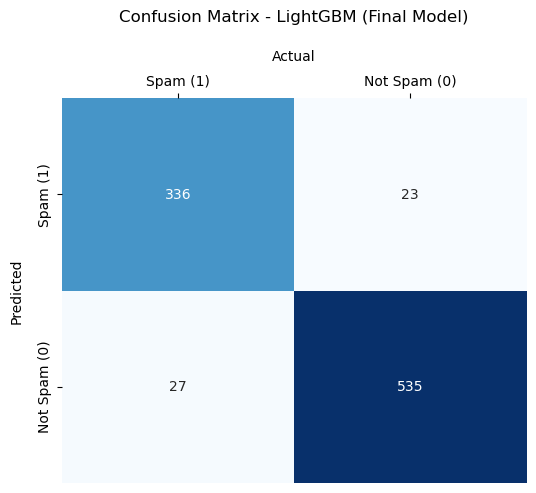

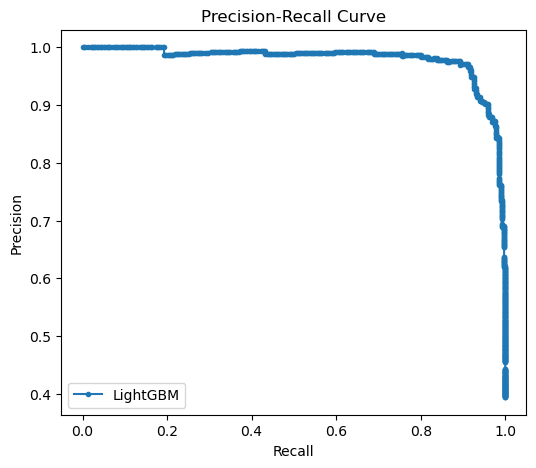

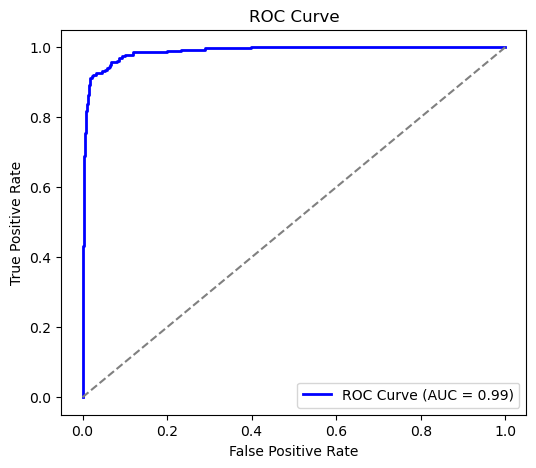

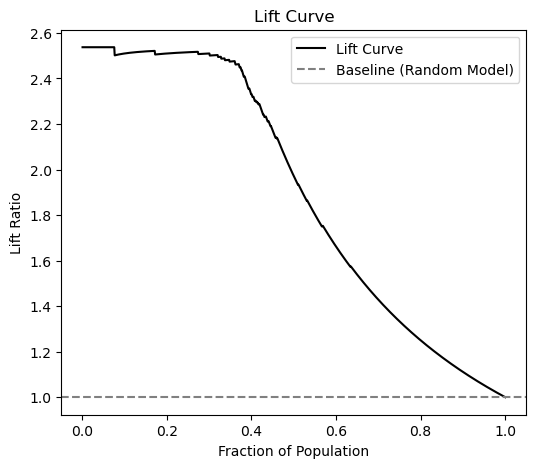

In [42]:
# === Confusion Matrix
conf_matrix = confusion_matrix(y_test_main, y_pred_final)
confusion_matrices = [conf_matrix]

selected_fold_cm = confusion_matrices[-1]
selected_fold_cm_plot = np.array([
    [selected_fold_cm[1, 1], selected_fold_cm[0, 1]],  
    [selected_fold_cm[1, 0], selected_fold_cm[0, 0]]   
])

plt.figure(figsize=(6, 5))
ax = sns.heatmap(selected_fold_cm_plot, annot=True, fmt='g', cmap='Blues', cbar=False, 
                 xticklabels=['Spam (1)', 'Not Spam (0)'], 
                 yticklabels=['Spam (1)', 'Not Spam (0)'])
ax.xaxis.set_ticks_position('top')  
ax.xaxis.set_label_position('top')
plt.title('Confusion Matrix - LightGBM (Final Model)', pad=20, loc='center')
plt.xlabel('Actual', labelpad=10)
plt.ylabel('Predicted', labelpad=10)
plt.show()

# === Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_main, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker='.', label="LightGBM")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# === ROC Curve
fpr, tpr, _ = roc_curve(y_test_main, y_pred_proba)
roc_auc = roc_auc_score(y_test_main, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# === Lift Curve
lift_df = pd.DataFrame({"prob": y_pred_proba, "spam_actual": (y_test_main == 1).astype(int)})
lift_df = lift_df.sort_values(by="prob", ascending=False).reset_index(drop=True)
lift_df["x"] = (lift_df.index + 1) / len(lift_df)
lift_df["y"] = (lift_df["spam_actual"].cumsum() / lift_df["spam_actual"].sum()) / lift_df["x"]

plt.figure(figsize=(6, 5))
plt.plot(lift_df["x"], lift_df["y"], color='black', lw=1.5, label="Lift Curve")
plt.axhline(y=1, color='grey', linestyle="--", label="Baseline (Random Model)")
plt.xlabel("Fraction of Population")
plt.ylabel("Lift Ratio")
plt.title("Lift Curve")
plt.legend()
plt.show()
